In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import sample
import os
import tensorflow as tf
import evaluation_metrics

In [2]:
# Trained tensorflow model

model_fullname = r"c:\Data\BreastSegmentation\SavedModels\BreastSegmentationStudy-TF2_model-2_2020-06-17_23-06-14.h5"

# Input segmentation

segmentation_fullname = r"c:\Data\BreastSegmentation\DataArrays\segmentation-027.npy"

# Input ultrasound

ultrasound_fullname = r"c:\Data\BreastSegmentation\DataArrays\ultrasound-027.npy"


acceptable_margin_mm = 1.0
mm_per_pixel = 1.0

roc_thresholds = [0.9, 0.8, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1,
                  0.08, 0.06, 0.04, 0.02, 0.01,
                  0.008, 0.006, 0.004, 0.002, 0.001]

In [3]:
# Check if keras model file exists. Abort if not found. Load model otherwise.

if not os.path.exists(model_fullname):
    raise Exception("Could not find model: " + model_fullname)

print("Loading model from: " + model_fullname)

model = tf.keras.models.load_model(model_fullname, compile=False)

Loading model from: c:\Data\BreastSegmentation\SavedModels\BreastSegmentationStudy-TF2_model-2_2020-06-17_23-06-14.h5


In [4]:
ultrasound_array = np.load(ultrasound_fullname)
segmentation_array = np.load(segmentation_fullname)

print("Ultrasound array shape:   {}".format(ultrasound_array.shape))
print("Segmentation array shape: {}".format(segmentation_array.shape))

Ultrasound array shape:   (226, 128, 128, 1)
Segmentation array shape: (226, 128, 128, 1)


In [5]:
val_best_metrics    = dict()
val_fuzzy_metrics   = dict()
#val_aurocs          = np.zeros(1)
#val_best_thresholds = np.zeros(1)

prediction = model.predict(ultrasound_array)

vali_metrics_dicts, vali_best_threshold_index, vali_area = evaluation_metrics.compute_roc(
    roc_thresholds, prediction, segmentation_array, acceptable_margin_mm, mm_per_pixel)

# val_fuzzy_metrics is a dict
val_fuzzy_metrics = evaluation_metrics.compute_evaluation_metrics(
    prediction, segmentation_array, acceptable_margin_mm, mm_per_pixel)

#print(vali_metrics_dicts)

val_best_metrics    = vali_metrics_dicts[vali_best_threshold_index]
val_aurocs          = vali_area
val_best_thresholds = roc_thresholds[vali_best_threshold_index]

print(val_best_metrics)
print(val_fuzzy_metrics)

{'true_positive_rate': 0.8599076725296558, 'false_positive_rate': 0.08482018805668656, 'specificity': 0.9151798119433134, 'precision': 0.1939151472983444, 'dice': 0.31646519669934775, 'jaccard': 0.18797662874500856, 'accuracy': 0.913898662846719, 'f_score': 0.31646519669934775}
{'true_positive_rate': 0.34244621817910587, 'false_positive_rate': 0.0080472360193675, 'specificity': 0.9919527639806325, 'precision': 0.5017796714227376, 'dice': 0.40707718859205105, 'jaccard': 0.2555536185913771, 'accuracy': 0.9769361938513573, 'f_score': 0.40707718859205105}


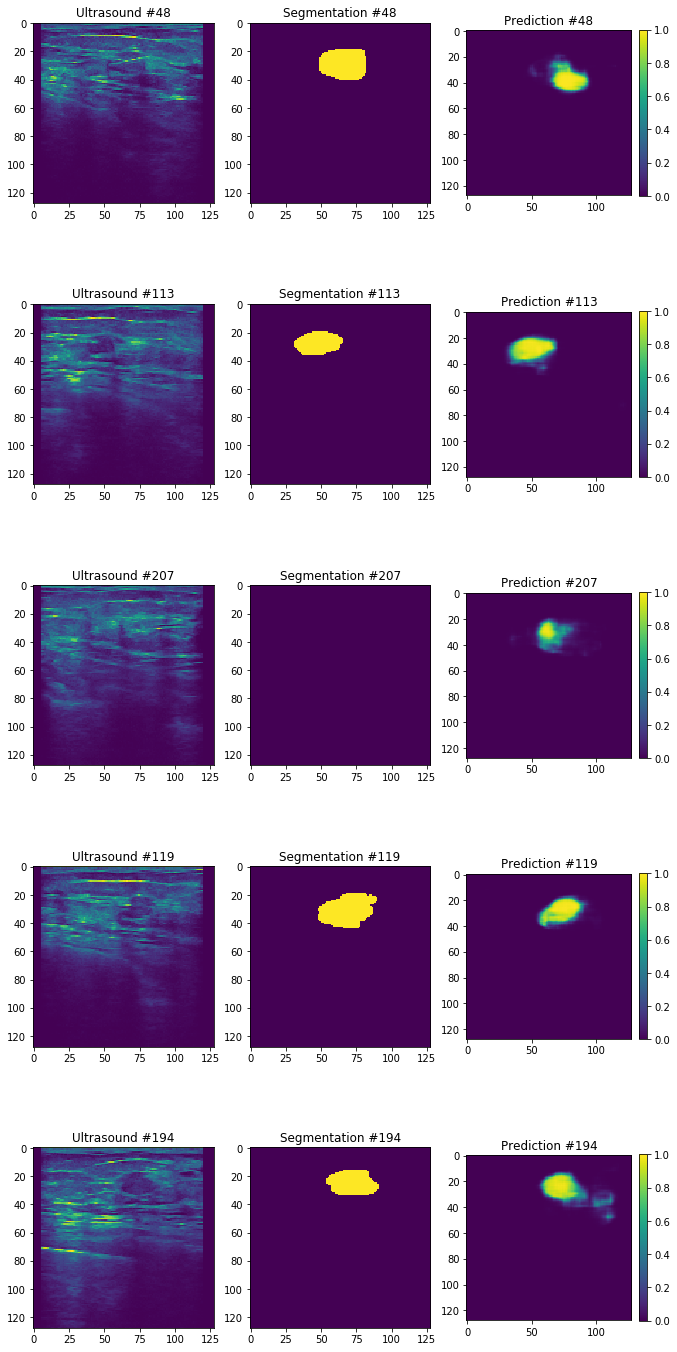

In [6]:
num_images = ultrasound_array.shape[0]
num_col = 3
num_show = 5

indices = [i for i in range(num_images)]
sample_indices = sample(indices, num_show)

fig = plt.figure(figsize=(11, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show, num_col, i*num_col+1)
    img0 = a0.imshow(np.flipud(ultrasound_array[sample_indices[i], :, :, 0].astype(np.float32)))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    
    a1 = fig.add_subplot(num_show, num_col, i*num_col+2)
    img1 = a1.imshow(np.flipud(segmentation_array[sample_indices[i], :, :, 0]), vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))

    a2 = fig.add_subplot(num_show, num_col, i*num_col+3)
    img2 = a2.imshow(np.flipud(prediction[sample_indices[i], :, :, 1]), vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)